In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
import time
import itertools
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
from numpy.random import seed
seed(1)

In [3]:
#df_bin = pd.read_csv('data/7Mfinal_balanced_bin_filter_scaf.csv')
df_bin = pd.read_csv('data/final_data.csv')

In [6]:
df_bin['steps_bins'] = pd.cut(df_bin['number_of_steps'], [0,1,3,6,10], labels=False)
df_bin.steps_bins.value_counts()

1    5581
0    5004
2    3826
3    3765
Name: steps_bins, dtype: int64

In [7]:
y_bin = np.array(df_bin.steps_bins).ravel()
y_ste = np.array(df_bin.number_of_steps).ravel()
x = np.array(df_bin[['syba', 'sascore', 'scscore', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']])
x = StandardScaler().fit_transform(x)

In [8]:
#x = StandardScaler().fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(x, y_bin, test_size=0.25, random_state=1)
X_train_ste, X_test_ste, y_train_ste, y_test_ste = train_test_split(x, y_ste, test_size=0.25, random_state=1)

In [9]:
def cross_scoring(model, X, Y):
    score = {'r2':'r2',
         'MAE':'neg_mean_absolute_error',
         'MSE':'neg_mean_squared_error',
         'RMSE':'neg_root_mean_squared_error'}
    scores = cross_validate(model, X, Y, scoring=score, cv=10)
    return scores

In [10]:
def vizualization_metrics(df):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.tight_layout(pad=5.0)
    sns.barplot(ax=axes[0,0], data=df, x="model", y="test_r2")
    axes[0,0].set_title('R2')
    #axes[0,0].tick_params(axis='x', rotation=45)
    sns.barplot(ax=axes[0,1], data=df, x="model", y="test_MAE")
    axes[0,1].set_title('MAE')
    sns.barplot(ax=axes[1,0], data=df, x="model", y="test_MSE")
    axes[1,0].set_title('MSE')
    sns.barplot(ax=axes[1,1], data=df, x="model", y="test_RMSE")
    axes[1,1].set_title('RMSE')
    #axes[1,0].grid()

In [11]:
def return_std(results):
    model_std =  np.array(results.cv_results_['std_test_score']) 
    model_mse =  np.array((-1)*results.cv_results_['mean_test_score'])
    std = 0
    for i in range(len(model_mse)):
        if model_mse[i] + results.best_score_ == 0:
            std = model_std[i]
    print('Best STD: %0.4f' % std)
    return std

def return_round_predict(model, X_train, y_train, X_test, limit):
    model_fit = model.fit(X_train, y_train)
    predict = model_fit.predict(X_test)
    predict_r = np.array([round(y) for y in predict])
    for i in range(len(predict_r)):
        if predict_r[i] > limit:
            predict_r[i] = limit
    return predict_r  

In [12]:
#models = ['RFR','XGB','SVR','KNR']
names = ['KNR','RFR', 'SVR','XGB','MLP']
RFR = RandomForestRegressor(random_state=0)
XGB = xgb.XGBRegressor(seed=0)
SV = SVR()
KNR = KNeighborsRegressor()
MLP = MLPRegressor(random_state=0, max_iter=1000)

### Groups

In [95]:
score_RFR = cross_scoring(RFR, x, y_bin)
score_XGB = cross_scoring(XGB, x, y_bin)
score_SVR = cross_scoring(SV, x, y_bin)
score_KNR = cross_scoring(KNR, x, y_bin)
score_MLP = cross_scoring(MLP, x, y_bin)

In [96]:
d1 = pd.DataFrame.from_dict(score_RFR)
d1['model']='RFR'
d2 = pd.DataFrame.from_dict(score_XGB)
d2['model']='XGB'
d3 = pd.DataFrame.from_dict(score_SVR)
d3['model']='SVR'
d4 = pd.DataFrame.from_dict(score_KNR)
d4['model']='KNR'
d5 = pd.DataFrame.from_dict(score_MLP)
d5['model']='MLP'

In [97]:
frames = [d1,d2,d3,d4,d5]
df_scores = pd.concat(frames)

In [98]:
df_scores['test_MSE'] = -1*df_scores['test_MSE']
df_scores['test_MAE'] = -1*df_scores['test_MAE']
df_scores['test_RMSE'] = -1*df_scores['test_RMSE']

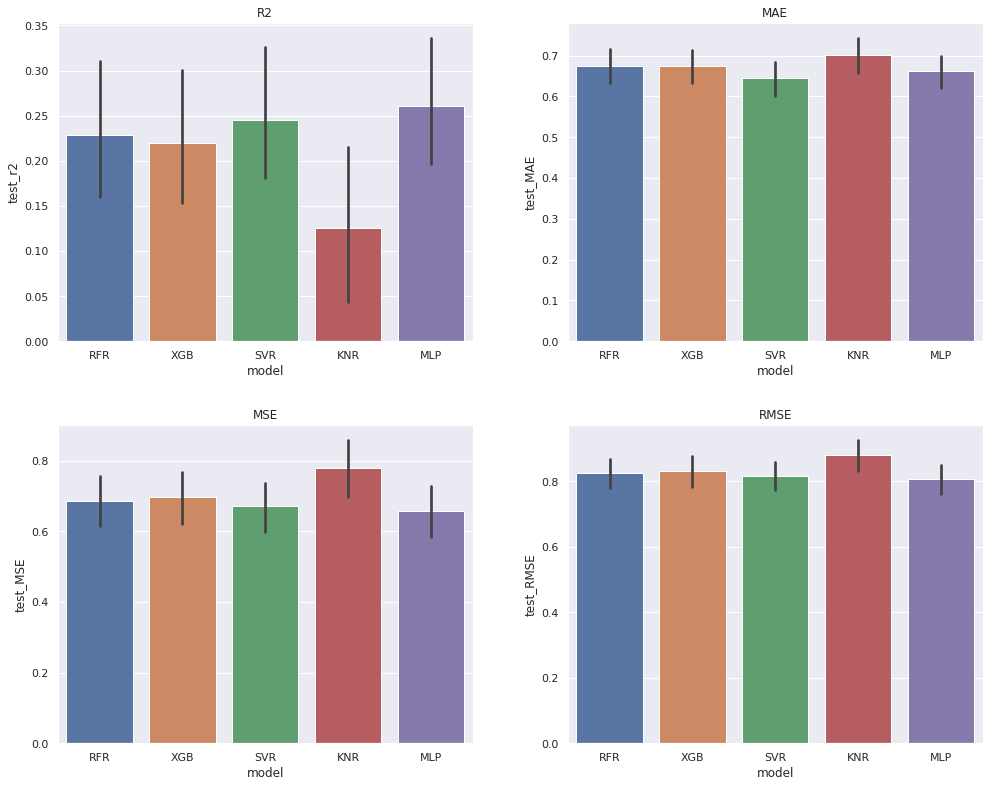

In [326]:
vizualization_metrics(df_scores)

In [279]:
bases_all = [('KNR',KNR), ('RFR',RFR), ('SVR',SV), ('XGB',XGB), ('MLP',MLP)]
mse_models = []
std_models = []
for base in bases_all:
    print(base[0])
    cross_model = cross_val_score(base[1], x, y_bin, scoring='neg_mean_squared_error', cv=10)
    print("MSE: %0.3f, STD: %0.3f" % (-cross_model.mean(), cross_model.std()))
    mse_models.append(-cross_model.mean())
    std_models.append(cross_model.std())

KNR
MSE: 0.779, STD: 0.132
RFR
MSE: 0.687, STD: 0.119
SVR
MSE: 0.672, STD: 0.112
XGB
MSE: 0.696, STD: 0.123
MLP
MSE: 0.659, STD: 0.114


In [280]:
MSE_models_no_opt = pd.DataFrame(zip(names, mse_models, std_models), columns=['MODEL', 'MSE', 'STD']).sort_values(['MSE'])
MSE_models_no_opt

,MODEL,MSE,STD
4,MLP,0.659177,0.114136
2,SVR,0.672467,0.112113
1,RFR,0.687252,0.118765
3,XGB,0.696303,0.123216
0,KNR,0.778808,0.131540


In [281]:
MSE_models_no_opt.to_csv('df_models.txt', index=None, sep=' ', mode='a')

### Steps

In [78]:
score_RFR_ste = cross_scoring(RFR, x, y_ste)
score_XGB_ste = cross_scoring(XGB, x, y_ste)
score_SVR_ste = cross_scoring(SV, x, y_ste)
score_KNR_ste = cross_scoring(KNR, x, y_ste)
score_MLP_ste = cross_scoring(MLP, x, y_ste)

In [127]:
d1 = pd.DataFrame.from_dict(score_RFR_ste)
d1['model']='RFR'
d2 = pd.DataFrame.from_dict(score_XGB_ste)
d2['model']='XGB'
d3 = pd.DataFrame.from_dict(score_SVR_ste)
d3['model']='SVR'
d4 = pd.DataFrame.from_dict(score_KNR_ste)
d4['model']='KNR'
d5 = pd.DataFrame.from_dict(score_MLP_ste)
d5['model']='MLP'

In [128]:
frames = [d1,d2,d3,d4,d5]
df_scores_ste = pd.concat(frames)
df_scores_ste['test_MSE'] = -1*df_scores_ste['test_MSE']
df_scores_ste['test_MAE'] = -1*df_scores_ste['test_MAE']
df_scores_ste['test_RMSE'] = -1*df_scores_ste['test_RMSE']

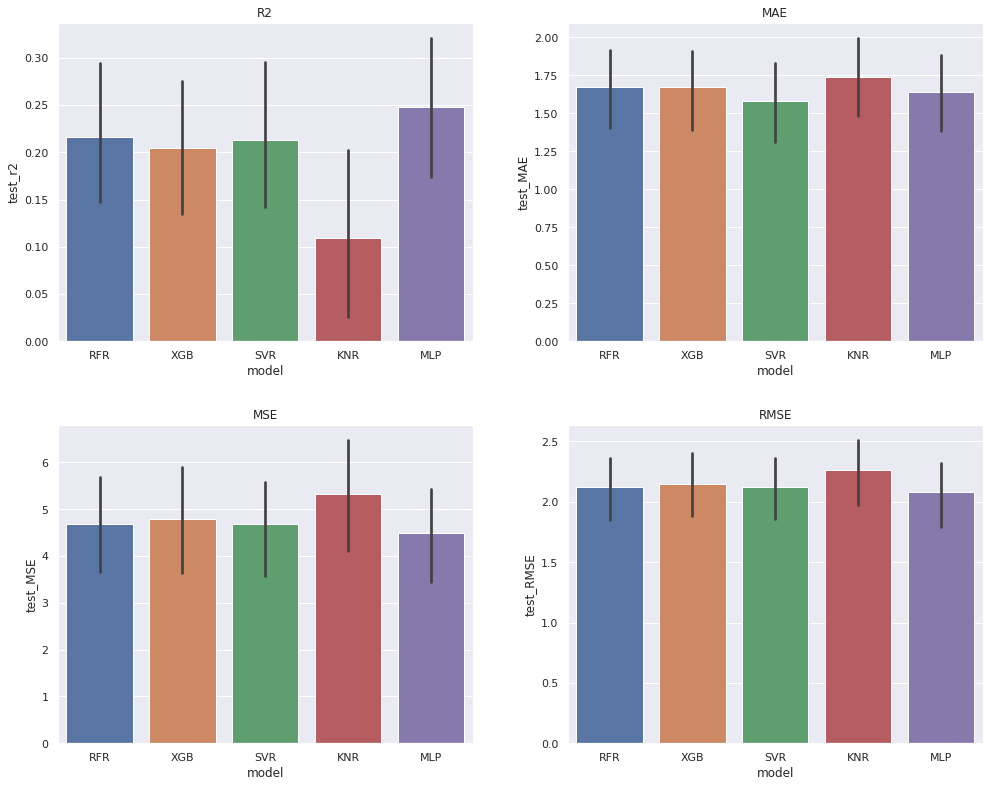

In [129]:
vizualization_metrics(df_scores_ste)

In [282]:
mse_models_steps = []
std_models_steps = []
for base in bases_all:
    print(base[0])
    cross_model = cross_val_score(base[1], x, y_ste, scoring='neg_mean_squared_error', cv=10)
    print("MSE: %0.3f, STD: %0.3f" % (-cross_model.mean(), cross_model.std()))
    mse_models_steps.append(-cross_model.mean())
    std_models_steps.append(cross_model.std())

KNR
MSE: 5.327, STD: 1.907
RFR
MSE: 4.685, STD: 1.662
SVR
MSE: 4.682, STD: 1.619
XGB
MSE: 4.787, STD: 1.751
MLP
MSE: 4.496, STD: 1.590


In [283]:
MSE_models_no_opt_ste = pd.DataFrame(zip(names, mse_models_steps, std_models_steps), 
                                     columns=['MODEL', 'MSE', 'STD']).sort_values(['MSE'])
MSE_models_no_opt_ste

,MODEL,MSE,STD
4,MLP,4.495560,1.590461
2,SVR,4.681750,1.619074
1,RFR,4.684591,1.662291
3,XGB,4.786904,1.750987
0,KNR,5.327381,1.906894


In [284]:
MSE_models_no_opt_ste.to_csv('df_models_steps.txt', index=None, sep=' ', mode='a')

# Hyperparametric optimization

### Groups

In [245]:
#KNR
start = time.time()
params = {'n_neighbors' : [10, 15, 20], 
          'weights': ['uniform', 'distance'], 
          'p':[1,2],
          'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}
search = GridSearchCV(KNR, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=10)
results_KNR = search.fit(x, y_bin)
print('Best MSE: %0.3f' % -results_KNR.best_score_)
print('Best Hyperparameters: %s' % results_KNR.best_params_) #sorted(clf.cv_results_.keys())
print("%0.3f min"%((time.time()-start)/60))
knr_std = return_std(results_KNR)

Best MSE: 0.687
Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 20, 'p': 2, 'weights': 'distance'}
0.285 min
Best STD: 0.1157


In [246]:
#RFR
start = time.time()
params = { 'max_depth': [5, 8, 15, 20],
           'n_estimators': [50, 100, 300, 400]}
search = GridSearchCV(RFR, params,scoring='neg_mean_squared_error', n_jobs=-1, cv=10)
results_RFR = search.fit(x, y_bin)
print('Best MSE: %0.3f' % -results_RFR.best_score_)
print('Best Hyperparameters: %s' % results_RFR.best_params_)
print("%0.3f min"%((time.time()-start)/60))
rfr_std = return_std(results_RFR)

Best MSE: 0.666
Best Hyperparameters: {'max_depth': 8, 'n_estimators': 400}
2.411 min
Best STD: 0.1193


In [247]:
#SVR
start = time.time()
params = {'C': [0.01, 0.1, 1.0, 5], 
          'epsilon': [0.01, 0.1, 0.5, 1.0, 5.0]} 
search = GridSearchCV(SV, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=10)
results_SVR = search.fit(x, y_bin)
print('Best MSE: %0.3f' % -results_SVR.best_score_)
print('Best Hyperparameters: %s' % results_SVR.best_params_)
print("%0.3f min"%((time.time()-start)/60))
svr_std = return_std(results_SVR)

Best MSE: 0.666
Best Hyperparameters: {'C': 0.1, 'epsilon': 0.5}
2.831 min
Best STD: 0.1098


In [248]:
#XGB
start = time.time()
params = { 'max_depth': [3, 6, 10], 
           'learning_rate': [0.01, 0.1, 0.5],
           'n_estimators': [50, 75, 100]}
search = GridSearchCV(XGB, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=10)
results_XGB = search.fit(x, y_bin)
print('Best MSE: %0.3f' % -results_XGB.best_score_)
print('Best Hyperparameters: %s' % results_XGB.best_params_)
print("%0.3f min"%((time.time()-start)/60))
xgb_std = return_std(results_XGB)

Best MSE: 0.663
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50}
20.111 min
Best STD: 0.1177


In [295]:
#MLP
neurons = (8, 12, 16)
layers = []
for i in range(1,4):
    layers = layers +[x for x in itertools.product(neurons,repeat=i)]
    
start = time.time()
params = {'hidden_layer_sizes': layers}
search = GridSearchCV(MLP, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=10)
results_MLP = search.fit(x, y_bin)
print('Best MSE: %0.3f' % -results_MLP.best_score_)
print('Best Hyperparameters: %s' % results_MLP.best_params_)
print("%0.3f min"%((time.time()-start)/60))
mlp_std = return_std(results_MLP)

Best MSE: 0.652
Best Hyperparameters: {'hidden_layer_sizes': (16, 8)}
2.503 min
Best STD: 0.1121


- ALL

In [297]:
mse_all = [-results_KNR.best_score_, -results_RFR.best_score_, -results_SVR.best_score_,
          -results_XGB.best_score_, -results_MLP.best_score_]
std_all = [knr_std,  rfr_std, svr_std, xgb_std, mlp_std]
MSE_models = pd.DataFrame(zip(names, mse_all, std_all), columns=['MODEL', 'MSE', 'STD']).sort_values(['MSE'])
MSE_models

,MODEL,MSE,STD
4,MLP,0.652367,0.112051
3,XGB,0.662614,0.117730
2,SVR,0.665547,0.109784
1,RFR,0.665547,0.119282
0,KNR,0.686739,0.115715


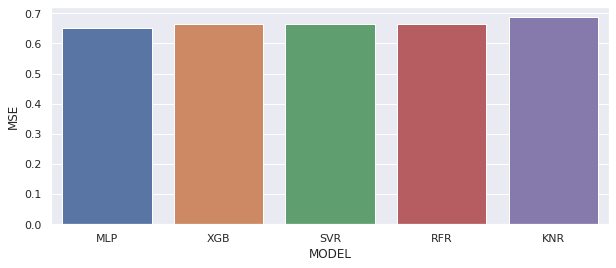

In [298]:
g = sns.barplot(x='MODEL', y='MSE', data=MSE_models)

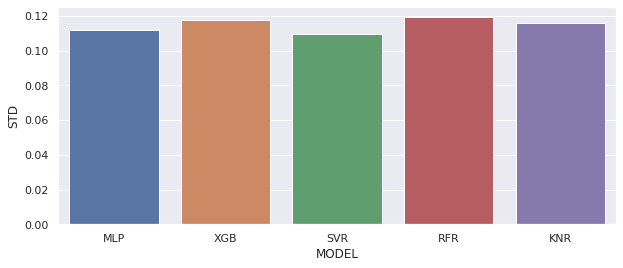

In [299]:
g = sns.barplot(x='MODEL', y='STD', data=MSE_models)

In [300]:
MSE_models.to_csv('df_optimized_models.txt', index=None, sep=' ', mode='a')

### Steps

In [263]:
#KNR
start = time.time()
params = {'n_neighbors' : [15, 25, 50, 75], 
          'weights': ['uniform', 'distance'], 
          'p':[1,2],
          'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}
search = GridSearchCV(KNR, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=10)
results_KNR_steps = search.fit(x, y_ste)
print('Best MSE: %0.3f' % -results_KNR_steps.best_score_)
print('Best Hyperparameters: %s' % results_KNR_steps.best_params_) 
print("%0.3f min"%((time.time()-start)/60))
knr_std_steps = return_std(results_KNR_steps)

Best MSE: 4.594
Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 50, 'p': 2, 'weights': 'distance'}
0.358 min
Best STD: 1.6241


In [264]:
#RFR
start = time.time()
params = { 'max_depth': [5, 8, 15, 20],
           'n_estimators': [50, 100, 300, 400]}
search = GridSearchCV(RFR, params,scoring='neg_mean_squared_error', n_jobs=-1, cv=10)
results_RFR_steps = search.fit(x, y_ste)
print('Best MSE: %0.3f' % -results_RFR_steps.best_score_)
print('Best Hyperparameters: %s' % results_RFR_steps.best_params_)
print("%0.3f min"%((time.time()-start)/60))
rfr_std_steps = return_std(results_RFR_steps)

Best MSE: 4.539
Best Hyperparameters: {'max_depth': 8, 'n_estimators': 400}
2.491 min
Best STD: 1.6283


In [265]:
#SVR
start = time.time()
params = {'C': [0.01, 0.1, 1.0, 5], 
          'epsilon': [0.01, 0.1, 0.5, 1.0, 5.0]} 
search = GridSearchCV(SV, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=10)
results_SVR_steps = search.fit(x, y_ste)
print('Best MSE: %0.3f' % -results_SVR_steps.best_score_)
print('Best Hyperparameters: %s' % results_SVR_steps.best_params_)
print("%0.3f min"%((time.time()-start)/60))
svr_std_steps = return_std(results_SVR_steps)

Best MSE: 4.582
Best Hyperparameters: {'C': 1.0, 'epsilon': 1.0}
3.237 min
Best STD: 1.6060


In [266]:
#XGB
start = time.time()
params = { 'max_depth': [3, 6, 9],
           'learning_rate': [0.01, 0.1, 0.5],
           'n_estimators': [10, 20, 30]} # 'colsample_bytree': [0.4, 0.8, 1]
search = GridSearchCV(XGB, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=10)
results_XGB_steps = search.fit(x, y_ste)
print('Best MSE: %0.3f' % -results_XGB_steps.best_score_)
print('Best Hyperparameters: %s' % results_XGB_steps.best_params_)
print("%0.3f min"%((time.time()-start)/60))
xgb_std_steps = return_std(results_XGB_steps)
# mse 4.786904, std 1.750987

/home/zumrovad/.conda/envs/az/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best MSE: 4.574
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 30}
5.086 min
Best STD: 1.6561


In [268]:
#MLP
neurons = (20, 16)
layers = []
for i in range(1,4):
    layers = layers +[x for x in itertools.product(neurons,repeat=i)]
    
start = time.time()
params = {'hidden_layer_sizes': layers}
search = GridSearchCV(MLP, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=10)
results_MLP_steps = search.fit(x, y_ste)
print('Best Score: %s' % -results_MLP_steps.best_score_)
print('Best Hyperparameters: %s' % results_MLP_steps.best_params_)
print("%0.3f min"%((time.time()-start)/60))
mlp_std_steps = return_std(results_MLP_steps)

Best Score: 4.483246673407265
Best Hyperparameters: {'hidden_layer_sizes': (16, 20)}
1.705 min
Best STD: 1.5920


In [296]:
neurons = (12, 16, 20)
layers = []
for i in range(1,4):
    layers = layers +[x for x in itertools.product(neurons,repeat=i)]
start = time.time()
params = {'hidden_layer_sizes': layers}
search = GridSearchCV(MLP, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=10)
results_MLP_steps = search.fit(x, y_ste)
print('Best Score: %s' % -results_MLP_steps.best_score_)
print('Best Hyperparameters: %s' % results_MLP_steps.best_params_)
print("%0.3f min"%((time.time()-start)/60))
mlp_std_steps = return_std(results_MLP_steps)

Best Score: 4.469462595869886
Best Hyperparameters: {'hidden_layer_sizes': (12, 12, 20)}
4.011 min
Best STD: 1.6020


- ALL

In [301]:
mse_all_steps = [-results_KNR_steps.best_score_, -results_RFR_steps.best_score_, -results_SVR_steps.best_score_,
                -results_XGB_steps.best_score_, -results_MLP_steps.best_score_]
std_all_steps = [knr_std_steps,  rfr_std_steps, svr_std_steps, xgb_std_steps, mlp_std_steps]
MSE_models_steps = pd.DataFrame(zip(names, mse_all_steps, std_all_steps), columns=['MODEL', 'MSE', 'STD']).sort_values(['MSE'])
MSE_models_steps

,MODEL,MSE,STD
4,MLP,4.469463,1.602041
1,RFR,4.539355,1.628348
3,XGB,4.573952,1.656061
2,SVR,4.582360,1.606025
0,KNR,4.593536,1.624053


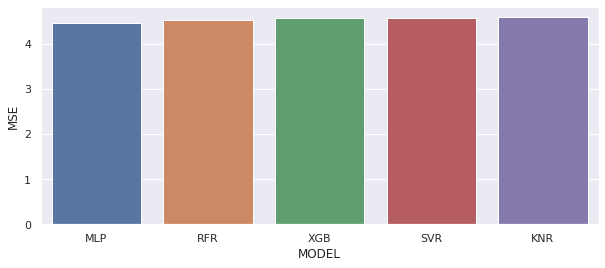

In [302]:
g = sns.barplot(x='MODEL', y='MSE', data=MSE_models_steps)

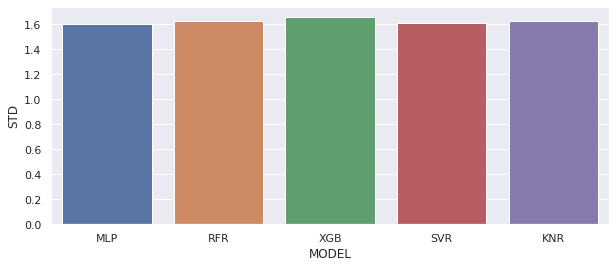

In [303]:
g = sns.barplot(x='MODEL', y='STD', data=MSE_models_steps)

In [304]:
MSE_models_steps.to_csv('df_optimized_models_steps.txt', index=None, sep=' ', mode='a')

# Group

In [12]:
MSE_models_no_opt = pd.read_csv('df_models.txt', sep=' ')
MSE_models = pd.read_csv('df_optimized_models.txt', sep=' ')

In [13]:
MSE_models['opt'] = 'optimized'
MSE_models_no_opt['opt'] = 'non-optimized'
frames = [MSE_models, MSE_models_no_opt]
df_models = pd.concat(frames)

In [14]:
df_models

,MODEL,MSE,STD,opt
0,MLP,0.652367,0.112051,optimized
1,XGB,0.662614,0.117730,optimized
2,SVR,0.665547,0.109784,optimized
3,RFR,0.665547,0.119282,optimized
4,KNR,0.686739,0.115715,optimized
0,MLP,0.659177,0.114136,non-optimized
1,SVR,0.672467,0.112113,non-optimized
2,RFR,0.687252,0.118765,non-optimized
3,XGB,0.696303,0.123216,non-optimized
4,KNR,0.778808,0.131540,non-optimized


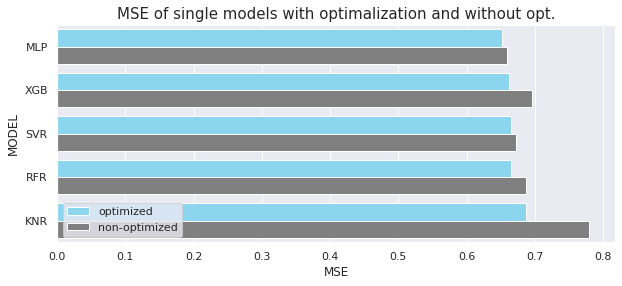

In [17]:
#sns.set(rc={'figure.figsize':(10,4)})
color2 = ['#7BDDFF', 'grey']
ax = sns.barplot(x="MSE", y="MODEL", hue="opt", data=df_models, palette=color2) 
#plt.title('MSE of single models with optimalization and without opt.', fontsize=15)
plt.legend(loc='lower left')

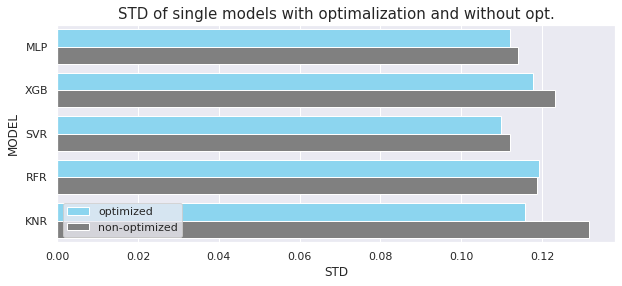

In [16]:
#sns.set(rc={'figure.figsize':(10,4)})
ax = sns.barplot(x="STD", y="MODEL", hue="opt", data=df_models, palette=color2)
#plt.title('STD of single models with optimalization and without opt.', fontsize=15)
plt.legend(loc='lower left')

In [11]:
RFR_opt = RandomForestRegressor(random_state=0, max_depth=8, n_estimators=400)
XGB_opt = xgb.XGBRegressor(seed=0, learning_rate=0.1, max_depth=6, n_estimators=50)
SV_opt = SVR(C=0.1, epsilon=0.5)
KNR_opt = KNeighborsRegressor(algorithm='auto', n_neighbors=20, p=2, weights='distance')
MLP_opt = MLPRegressor(random_state=0, max_iter=1000, hidden_layer_sizes=(16, 8))

In [311]:
score_RFR_opt = cross_scoring(RFR_opt, x, y_bin)
score_XGB_opt = cross_scoring(XGB_opt, x, y_bin)
score_SVR_opt = cross_scoring(SV_opt, x, y_bin)
score_KNR_opt = cross_scoring(KNR_opt, x, y_bin)
score_MLP_opt = cross_scoring(MLP_opt, x, y_bin)

In [312]:
d1_opt = pd.DataFrame.from_dict(score_RFR_opt)
d1_opt['model']='RFR'
d2_opt = pd.DataFrame.from_dict(score_XGB_opt)
d2_opt['model']='XGB'
d3_opt = pd.DataFrame.from_dict(score_SVR_opt)
d3_opt['model']='SVR'
d4_opt = pd.DataFrame.from_dict(score_KNR_opt)
d4_opt['model']='KNR'
d5_opt = pd.DataFrame.from_dict(score_MLP_opt)
d5_opt['model']='MLP'

In [313]:
frames_opt = [d1_opt, d2_opt, d3_opt, d4_opt, d5_opt]
df_scores_opt = pd.concat(frames_opt)

In [314]:
df_scores_opt['test_MSE'] = -1*df_scores_opt['test_MSE']
df_scores_opt['test_MAE'] = -1*df_scores_opt['test_MAE']
df_scores_opt['test_RMSE'] = -1*df_scores_opt['test_RMSE']

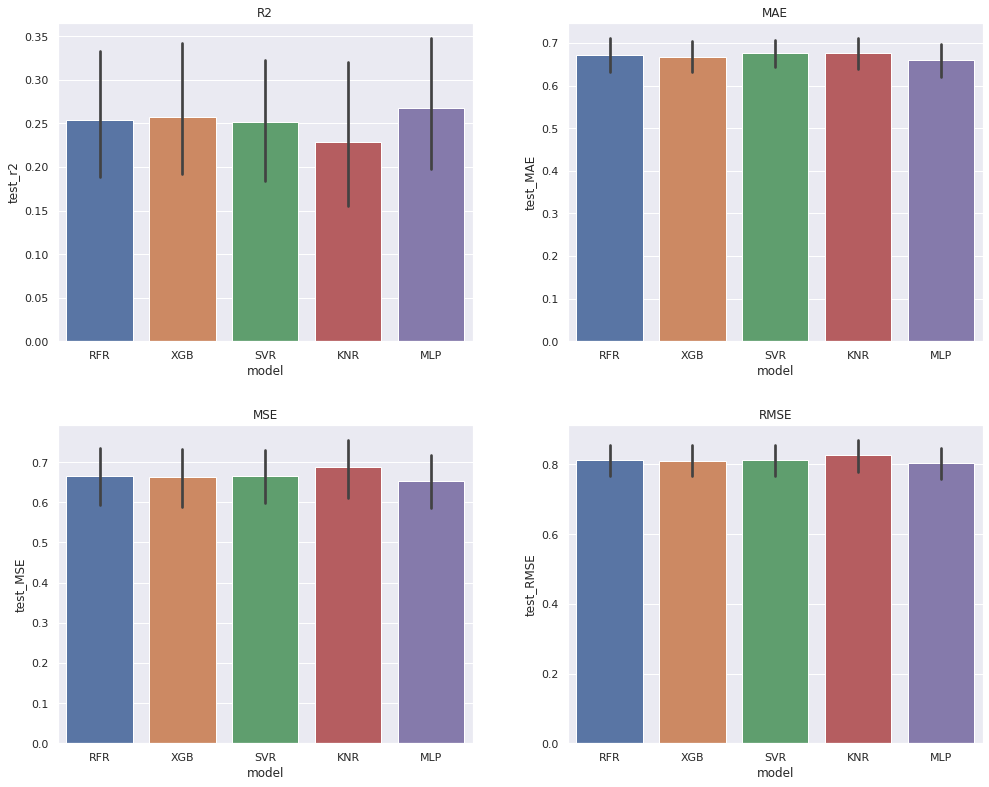

In [315]:
vizualization_metrics(df_scores_opt)

In [32]:
predict_RFR = return_round_predict(RFR_opt, X_train, y_train, X_test, 3)
predict_XGB = return_round_predict(XGB_opt, X_train, y_train, X_test, 3)
predict_SVR = return_round_predict(SV_opt, X_train, y_train, X_test, 3)
predict_KNR = return_round_predict(KNR_opt, X_train, y_train, X_test, 3)
predict_MLP = return_round_predict(MLP_opt, X_train, y_train, X_test, 3)

Text(0.5, 1.0, 'MLP test')

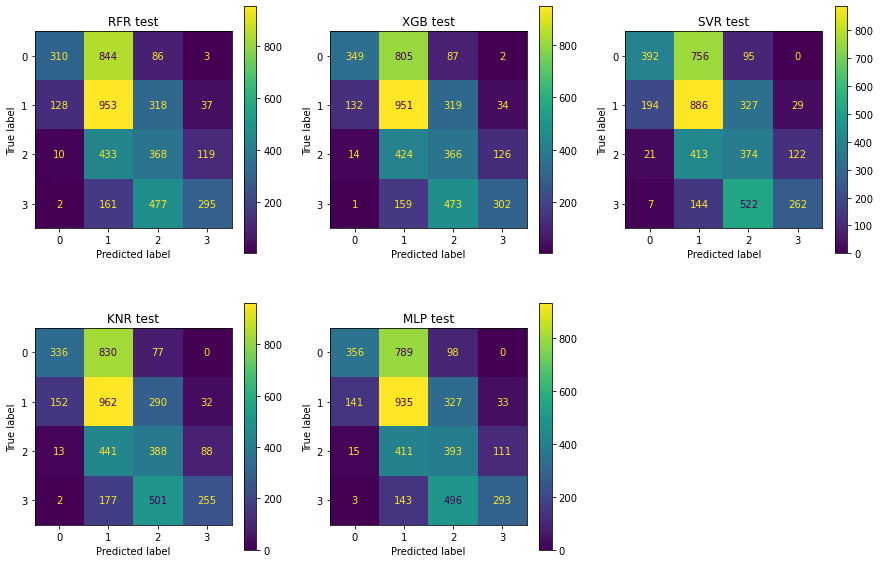

In [40]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
fig.delaxes(ax[1,2])
ConfusionMatrixDisplay(confusion_matrix(y_test, predict_RFR)).plot(ax=ax[0,0])
ConfusionMatrixDisplay(confusion_matrix(y_test, predict_XGB)).plot(ax=ax[0,1])
ConfusionMatrixDisplay(confusion_matrix(y_test, predict_SVR)).plot(ax=ax[0,2])
ConfusionMatrixDisplay(confusion_matrix(y_test, predict_KNR)).plot(ax=ax[1,0])
ConfusionMatrixDisplay(confusion_matrix(y_test, predict_MLP)).plot(ax=ax[1,1])
ax[0,0].set_title("RFR test")
ax[0,1].set_title("XGB test")
ax[0,2].set_title("SVR test")
ax[1,0].set_title("KNR test")
ax[1,1].set_title("MLP test")

# Steps

In [305]:
MSE_models_no_opt_steps = pd.read_csv('df_models_steps.txt', sep=' ')
MSE_models_steps = pd.read_csv('df_optimized_models_steps.txt', sep=' ')

In [306]:
MSE_models_steps['opt'] = 'optimized'
MSE_models_no_opt_steps['opt'] = 'non-optimized'
frames_steps = [MSE_models_steps, MSE_models_no_opt_steps]
df_models_steps = pd.concat(frames_steps)

In [307]:
df_models_steps

,MODEL,MSE,STD,opt
0,MLP,4.469463,1.602041,optimized
1,RFR,4.539355,1.628348,optimized
2,XGB,4.573952,1.656061,optimized
3,SVR,4.582360,1.606025,optimized
4,KNR,4.593536,1.624053,optimized
0,MLP,4.495560,1.590461,non-optimized
1,SVR,4.681750,1.619074,non-optimized
2,RFR,4.684591,1.662291,non-optimized
3,XGB,4.786904,1.750987,non-optimized
4,KNR,5.327381,1.906894,non-optimized


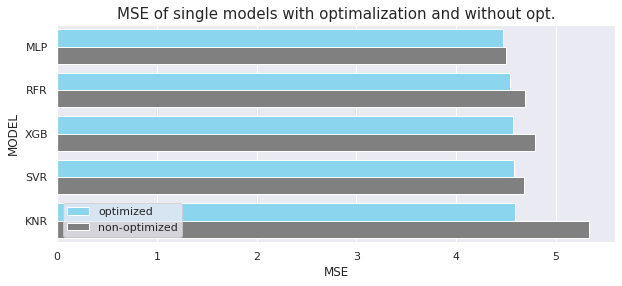

In [324]:
#sns.set(rc={'figure.figsize':(10,4)})
ax = sns.barplot(x="MSE", y="MODEL", hue="opt", data=df_models_steps, palette=color2) 
#plt.title('MSE of single models with optimalization and without opt.', fontsize=15)
plt.legend(loc='lower left')

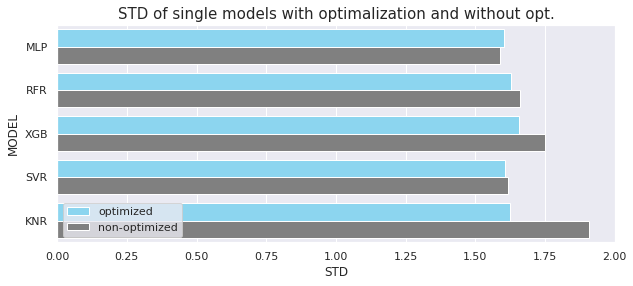

In [325]:
ax = sns.barplot(x="STD", y="MODEL", hue="opt", data=df_models_steps, palette=color2)
#plt.title('STD of single models with optimalization and without opt.', fontsize=15)
plt.legend(loc='lower left')

In [22]:
RFR_ste_opt = RandomForestRegressor(random_state=0, max_depth=8, n_estimators=400)
XGB_ste_opt = xgb.XGBRegressor(seed=0, learning_rate=0.1, max_depth=6, n_estimators=30)
SV_ste_opt = SVR(C=1.0, epsilon=1.0) 
KNR_ste_opt = KNeighborsRegressor(algorithm='auto', n_neighbors=50, p=2, weights='distance')
MLP_ste_opt = MLPRegressor(random_state=0, max_iter=1000, hidden_layer_sizes=(12, 12, 20))

In [317]:
score_RFR_ste_opt = cross_scoring(RFR_ste_opt, x, y_ste)
score_XGB_ste_opt = cross_scoring(XGB_ste_opt, x, y_ste)
score_SVR_ste_opt = cross_scoring(SV_ste_opt, x, y_ste)
score_KNR_ste_opt = cross_scoring(KNR_ste_opt, x, y_ste)
score_MLP_ste_opt = cross_scoring(MLP_ste_opt, x, y_ste)

In [318]:
d1_opt = pd.DataFrame.from_dict(score_RFR_ste_opt)
d1_opt['model']='RFR'
d2_opt = pd.DataFrame.from_dict(score_XGB_ste_opt)
d2_opt['model']='XGB'
d3_opt = pd.DataFrame.from_dict(score_SVR_ste_opt)
d3_opt['model']='SVR'
d4_opt = pd.DataFrame.from_dict(score_KNR_ste_opt)
d4_opt['model']='KNR'
d5_opt = pd.DataFrame.from_dict(score_MLP_ste_opt)
d5_opt['model']='MLP'

In [319]:
frames_opt = [d1_opt, d2_opt, d3_opt, d4_opt, d5_opt]
df_scores_ste_opt = pd.concat(frames_opt)
df_scores_ste_opt['test_MSE'] = -1*df_scores_ste_opt['test_MSE']
df_scores_ste_opt['test_MAE'] = -1*df_scores_ste_opt['test_MAE']
df_scores_ste_opt['test_RMSE'] = -1*df_scores_ste_opt['test_RMSE']

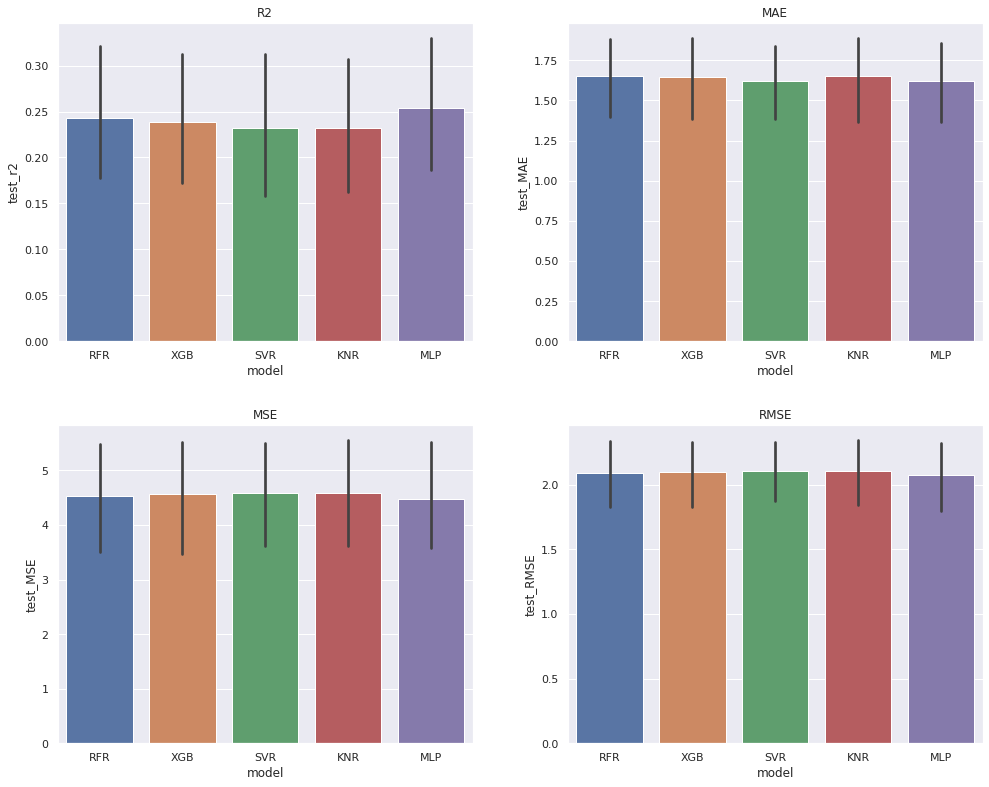

In [320]:
vizualization_metrics(df_scores_ste_opt)

In [34]:
predict_RFR_ste = return_round_predict(RFR_ste_opt, X_train_ste, y_train_ste, X_test_ste, 9)
predict_XGB_ste = return_round_predict(XGB_ste_opt, X_train_ste, y_train_ste, X_test_ste, 9)
predict_SVR_ste = return_round_predict(SV_ste_opt, X_train_ste, y_train_ste, X_test_ste, 9)
predict_KNR_ste = return_round_predict(KNR_ste_opt, X_train_ste, y_train_ste, X_test_ste, 9)
predict_MLP_ste = return_round_predict(MLP_ste_opt, X_train_ste, y_train_ste, X_test_ste, 9)

Text(0.5, 1.0, 'MLP test')

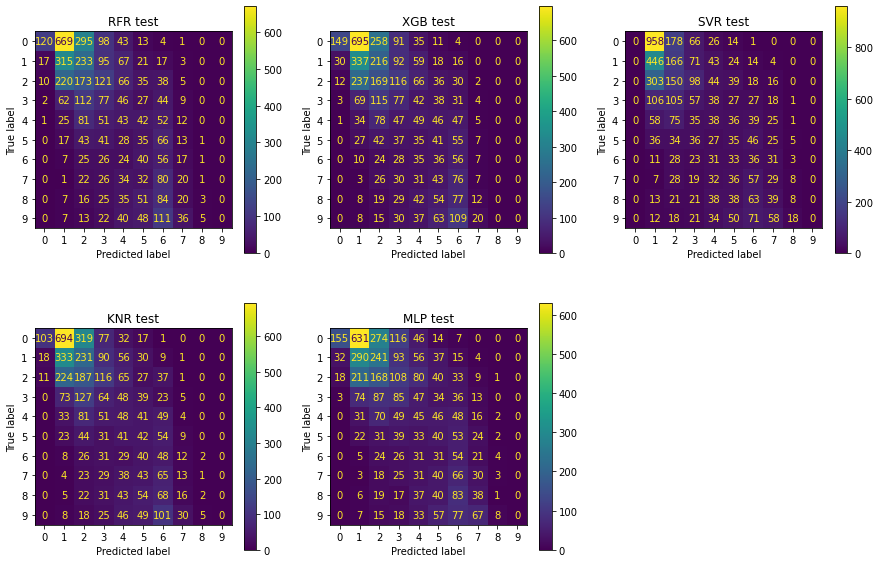

In [39]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
fig.delaxes(ax[1,2])
ConfusionMatrixDisplay(confusion_matrix(y_test_ste, predict_RFR_ste)).plot(ax=ax[0,0])
ConfusionMatrixDisplay(confusion_matrix(y_test_ste, predict_XGB_ste)).plot(ax=ax[0,1])
ConfusionMatrixDisplay(confusion_matrix(y_test_ste, predict_SVR_ste)).plot(ax=ax[0,2])
ConfusionMatrixDisplay(confusion_matrix(y_test_ste, predict_KNR_ste)).plot(ax=ax[1,0])
ConfusionMatrixDisplay(confusion_matrix(y_test_ste, predict_MLP_ste)).plot(ax=ax[1,1])
ax[0,0].set_title("RFR test")
ax[0,1].set_title("XGB test")
ax[0,2].set_title("SVR test")
ax[1,0].set_title("KNR test")
ax[1,1].set_title("MLP test")